In [2]:
import sys
sys.path.append('../../../patronus/')
from global_config import * # load REPO_HOME_DIR, DATASET_DIR

import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os


from train.utils import load_patronus_unet_model
from models.diffusion import SimpleDiffusion
from train.dataloader import get_dataloader
from analysis.analysis_utils import get_samples_from_loader, vis_samples
from analysis.interpretability.visualize_prototype import plot_vis_p,get_most_activated_patch_for_one
from train.dataloader import inverse_transform

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Consistency of Prototype Visualization
Fig. 6 in the paper.
## 1 - Define the dataset and trained version that you would like to inspect on

In [2]:
ds = 'CelebA'
version_num = 4
print(f'Selecting dataset: {ds} version {version_num}')

Selecting dataset: CelebA version 4


## 2 – Load trained model, initialize diffusion schedule, load test set

In [3]:
# ---- Load the patronus model -----
print('*'*30 + 'Load model' + '*'*30)
model, patronus_config_set = load_patronus_unet_model(ds_name=ds, 
                                                    version_num=version_num,
                            )

 # ---- Load the diffusion schduler ----
sd = SimpleDiffusion(
        num_diffusion_timesteps = patronus_config_set['TrainingConfig']['TIMESTEPS'],
        img_shape               = patronus_config_set['TrainingConfig']['IMG_SHAPE'],
        device                  = patronus_config_set['BaseConfig']['DEVICE'],
)

# ---- Load the test set ----- 
# we use test set to avoid memorization from the training set
dataloader_test = get_dataloader(
        dataset_name=f'{ds}-test',
        batch_size=256,
        device='cpu',
        shuffle = True, # test set should not be shuffled
)

# # ---- Get the plausible maximum prototype similarity score ----
for i, (b_image, extra_info) in enumerate(dataloader_test):
    pact = model.proactBlock(b_image.to(device))
    b_img_id = extra_info[1]
    max_pact = torch.max(pact).detach().cpu()
    break
# print(f'Maximum prototype similarity score: {max_pact}')

## Randomly select 5 samples

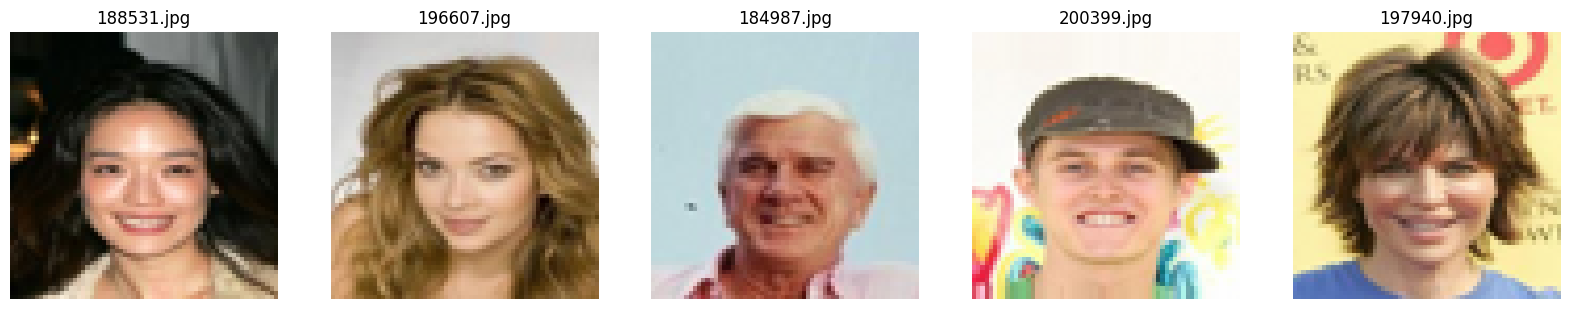

In [39]:
num_random_pick_samples = 5

torch.manual_seed(0) # <-- set random seed for reproducibility
batch_size = b_image.shape[0]
random_pick_samples_ind = torch.randperm(batch_size,)[:num_random_pick_samples]


# get the necessary variables
random_pick_pact = pact[random_pick_samples_ind]
random_pick_img = b_image[random_pick_samples_ind]
random_pick_img_id = [b_img_id[i] for i in random_pick_samples_ind]
random_pick_xT = sd.reverse_sample_loop(model,random_pick_img.to(device), 
                                       model_kwargs={'given_cond_vector':random_pick_pact})['sample']

# visualize the ramdomly picked samples
vis_samples(random_pick_img, random_pick_img_id)

## Select prototype indexes for consistency validation

In [52]:
selected_p_ind = [0,3,17,19,38]
print(f'Selected prototypes: {selected_p_ind}')

Selected prototypes: [0, 3, 17, 19, 38]


## 3 - Enhance each prototype for all randomly selected samples

In [53]:

enhanced_pact_chosen_p_all = []

for real_i,i_p in enumerate(selected_p_ind):
    enhanced_pact_chosen_p = random_pick_pact.clone()
    enhanced_pact_chosen_p[:,i_p] = max_pact.item()
    enhanced_pact_chosen_p_all.append(enhanced_pact_chosen_p)

enhanced_pact_chosen_p_all = torch.cat(enhanced_pact_chosen_p_all,dim=0)


random_pick_img_all = random_pick_img.repeat(len(selected_p_ind),1,1,1)
random_pick_xT_all = random_pick_xT.repeat(len(selected_p_ind),1,1,1)

this_x_0_enhanced_all = sd.sample(model,
                                shape=random_pick_img_all.shape ,
                                noise=random_pick_xT_all,
                                progress=True,
                                model_kwargs={'given_cond_vector':enhanced_pact_chosen_p_all},
                                num_samples=1)

DEBUG:img.shape=torch.Size([25, 3, 64, 64])


  0%|          | 0/1000 [00:00<?, ?it/s]

In [54]:
records = {}
num_selected_p =len(selected_p_ind)
for real_i,i_p in enumerate(selected_p_ind):
    this_x_0_enhanced = this_x_0_enhanced_all[real_i*num_random_pick_samples:(real_i+1)*num_random_pick_samples]
    this_p_act_all = model.proactBlock(this_x_0_enhanced)
    this_p_act = this_p_act_all[:,i_p]

    # Another way: do abstract before and after enhance p, and use the one that change the most
    this_p_act_all_original = model.proactBlock(random_pick_img.to(device))
    this_p_act_ori = this_p_act_all_original[:,i_p]

    # get the most activated patch for this image
    most_activated_patches_this =[]
    bounding_boxes_this = []
    for i in range(num_random_pick_samples):
        most_activated_patches_this_tmp,bounding_boxes_this_tmp = get_most_activated_patch_for_one(this_x_0_enhanced[i].unsqueeze(0),
                                                                 [i_p],
                                                                 model)
        most_activated_patches_this.append(most_activated_patches_this_tmp[0])
        bounding_boxes_this.append(bounding_boxes_this_tmp[0])

    this_p_act_nor_softmax = torch.nn.functional.softmax(this_p_act_all, dim=1)

    records[i_p] = {'ori_img': random_pick_img,
                                     'enhanced_img':this_x_0_enhanced,
                                     'enhanced_patch':most_activated_patches_this,
                                     'enhanced_b_box':bounding_boxes_this,
                                     'enhanced_p_act':this_p_act,
                                     'enhanced_p_act_nor':None,
                                     'ori_p_act':this_p_act_ori,
                                     }

In [55]:
def plot_consistency(records,
             save_pth = None):
    selected_p_ind = sorted(records.keys())
    print(f'{selected_p_ind=}')

    fig, ax = plt.subplots(len(selected_p_ind)*2+1,num_random_pick_samples,figsize=(num_random_pick_samples*1.5,len(selected_p_ind)*3.5),dpi=100)

    row_ind = 0
    ori_img = records[selected_p_ind[0]]['ori_img']
    for i in range(num_random_pick_samples):
        this_ori_img = ori_img[i]
        ax[row_ind, i].imshow(np.transpose(inverse_transform(this_ori_img).type(torch.uint8).cpu().squeeze().numpy(), (1, 2, 0)))
        # ax[row_ind, i].set_title('original img')
        ax[row_ind, i].axis('off')
        if i == num_random_pick_samples//2:
            ax[row_ind, i].set_title('Original img')
    row_ind += 1

    for i_p in selected_p_ind:
        # print(f'{i_p=}')
        # plot the most activated patch for each p
        patch = records[i_p]['enhanced_patch']
        g_img = records[i_p]['enhanced_img']
        bounding_boxes = records[i_p]['enhanced_b_box']

        for i in range(num_random_pick_samples):
            img = g_img[i]
            ax[row_ind, i].imshow(np.transpose(inverse_transform(img).type(torch.uint8).cpu().squeeze().numpy(), (1, 2, 0)))
            b_box = bounding_boxes[i]

            # plot the bounding box with red line
            ax[row_ind, i].plot([b_box[0],b_box[2]],[b_box[1],b_box[1]],'r')
            ax[row_ind, i].plot([b_box[0],b_box[2]],[b_box[3],b_box[3]],'r')
            ax[row_ind, i].plot([b_box[0],b_box[0]],[b_box[1],b_box[3]],'r')
            ax[row_ind, i].plot([b_box[2],b_box[2]],[b_box[1],b_box[3]],'r')
            
            # ax[row_ind,i].set_title(f'p{i}\np_act={pro_act_generated_img[i,i]:.2f}\nnor_p_act={pro_act_generated_img_nor[i,i]:.2f}')
            # ax[row_ind, i].set_title(f'pa={pro_act_generated_img[i]:.2f}')
            ax[row_ind, i].set_xlim([0, img.shape[1]])
            ax[row_ind, i].set_ylim([img.shape[2], 0]) 
            ax[row_ind, i].axis('off')
            ax[row_ind, i].tick_params(labelbottom=False)

            if i == num_random_pick_samples//2:
                ax[row_ind, i].set_title(f'Add prototype {i_p}')
        
        row_ind += 1


        # print(f'{len(patch)=}')
        # print(f'{patch[0].shape=}')
        for i in range(num_random_pick_samples):
            p = patch[i].squeeze(0)
            ax[row_ind, i].imshow(np.transpose(inverse_transform(p).type(torch.uint8).cpu().squeeze().numpy(), (1, 2, 0)))
            # ax[row_ind, i].set_title(f'p{i_p}')
            ax[row_ind, i].axis('off')
            if i == num_random_pick_samples//2:
                ax[row_ind, i].set_title(f'Vis of {i_p}')
            # break
        row_ind += 1
        # break

    plt.tight_layout(h_pad=0.5,w_pad=0.5)
    if save_pth is not None:
        plt.savefig(save_pth,bbox_inches='tight')
    plt.show()



selected_p_ind=[0, 3, 17, 19, 38]


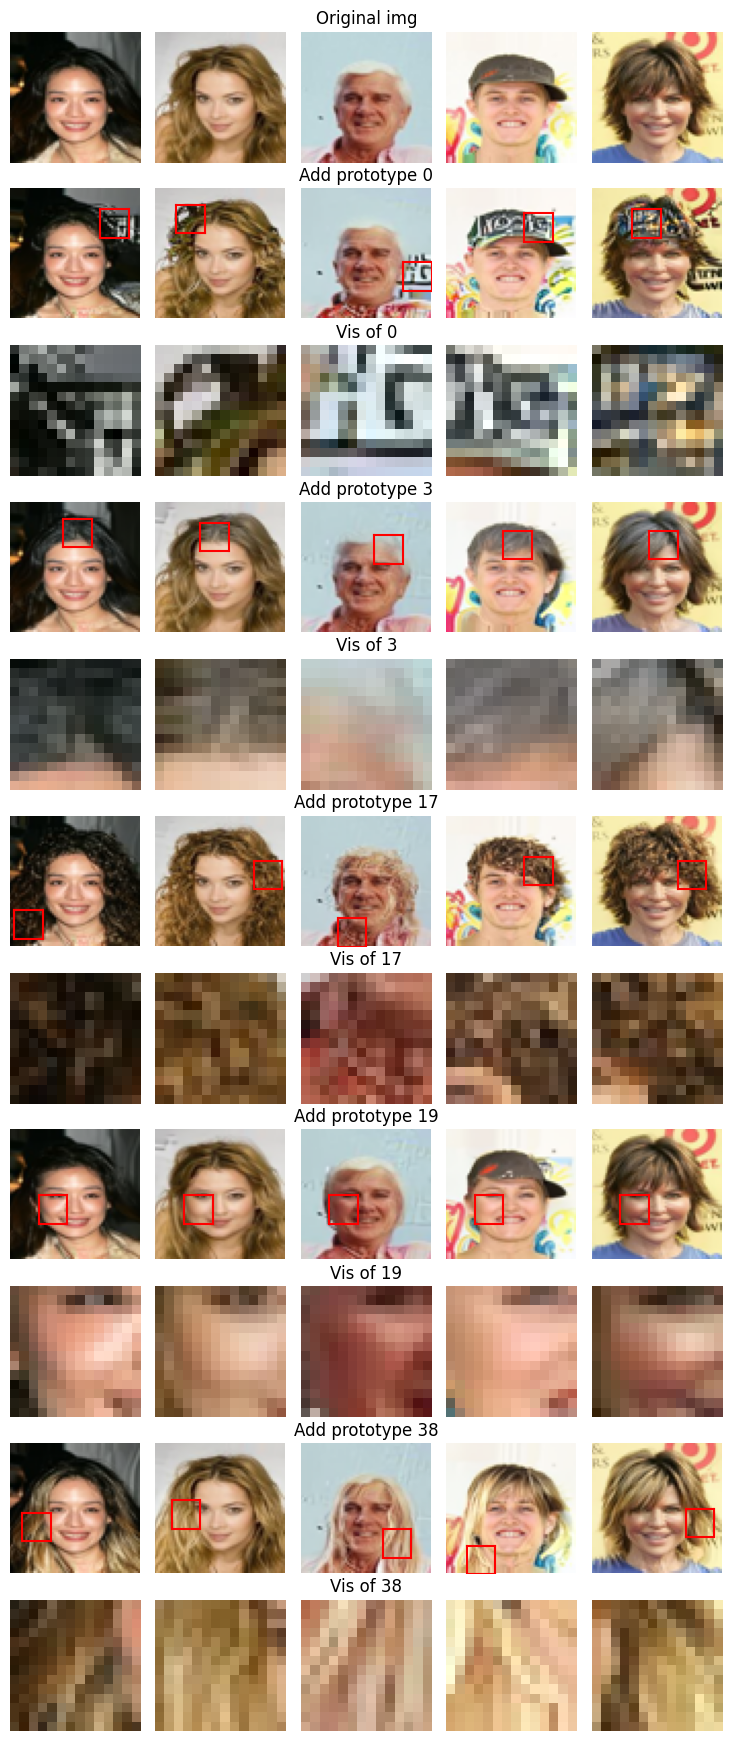

In [56]:
plot_consistency(records=records,save_pth =None)